# 1 Introduction - Histopathologic Cancer Detection

## Problem Statement

Cancer detection in histopathologic images is a critical task in medical diagnostics, helping pathologists identify metastatic tissue in lymph nodes. The **Histopathologic Cancer Detection** competition on Kaggle challenges participants to develop machine learning models capable of detecting cancerous regions in small image patches extracted from digital pathology scans.

Automating this process can significantly enhance diagnostic accuracy and efficiency, reducing the workload of pathologists and enabling faster decision-making in clinical settings. The primary objective is to build a classifier that determines whether an image contains metastatic tissue.

https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview

## Dataset Overview

https://www.kaggle.com/competitions/histopathologic-cancer-detection/data

The dataset consists of histopathologic images taken from lymph node sections. The dataset is divided into training and test sets, with labels indicating the presence (`1`) or absence (`0`) of cancerous tissue.

> For each `id` in the test set, you must predict a probability that center `32x32px` region of a patch contains at least one pixel of tumor tissue.

### Data Structure

- **Training Data**:

  - Contains **220k** images. Stored as **`.tif`** files.
  - Labels are provided in a CSV file (`train_labels.csv`), mapping **image IDs** to binary classifications.

- **Test Data**:

  - Contains **57.5k** of images for model evaluation.
  - Labels are not provided.

- The original PCam dataset contains uplicate images due to probabilistic sampling, however, this dataset for Kaggle does not.

## Goal

Participants must develop an **image classifier** to predict whether an image contains metastatic cancer cells. The model's performance is evaluated based on the **ROC AUC (Receiver Operating Characteristic Area Under the Curve)** metric, which measures the trade-off between predicted probability and the observed target.


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import copy
import os
import torch
from PIL import Image, ImageDraw
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
import plotly.express as px
from torchsummary import summary
from tqdm.notebook import trange, tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
import torch.optim as optim
import torchvision.models as models
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report, roc_curve, auc
from torch.nn.functional import softmax


%matplotlib inline

# 2 Exploratory Data Analysis (EDA)

- **Checking for Missing Values**  
  - It is essential to verify if there are any missing values in the dataset, as they can impact model performance. I check for null values in the labels file to ensure all images have corresponding labels, which they do.

- **Checking for Duplicates**  
  - Duplicate entries can skew the training process, leading to biased model performance. To check for this I examine the dataset for any duplicate image IDs and remove them if necessary. In this case there are no duplicates

- **Class Imbalance**  
  - A significant imbalance between classes can lead to a biased model that favors the majority class. I analyze the distribution of labels to determine if the dataset requires resampling techniques such as oversampling or undersampling. In this case there is a roughly 60/40 split of benign and malignant images.

- **Visualizing the Data**  
  - Visualizations help in understanding the dataset characteristics and identifying patterns so I will generate image samples to inspect the type of images we're working with.


In [11]:
# Load data
labels_df = pd.read_csv('train_labels.csv')
print(labels_df.head().to_markdown())
labels_df.shape

# Check for missing values
missing_values = labels_df.isnull().sum()
print("Missing values:\n", missing_values, "\n")

# Check for duplicates
duplicates = labels_df.duplicated().sum()
print("Number of duplicate rows:", duplicates)

# Check for class imbalance
labels_df['label'].value_counts()

|    | id                                       |   label |
|---:|:-----------------------------------------|--------:|
|  0 | f38a6374c348f90b587e046aac6079959adf3835 |       0 |
|  1 | c18f2d887b7ae4f6742ee445113fa1aef383ed77 |       1 |
|  2 | 755db6279dae599ebb4d39a9123cce439965282d |       0 |
|  3 | bc3f0c64fb968ff4a8bd33af6971ecae77c75e08 |       0 |
|  4 | 068aba587a4950175d04c680d38943fd488d6a9d |       0 |
Missing values:
 id       0
label    0
dtype: int64 

Number of duplicate rows: 0


label
0    130908
1     89117
Name: count, dtype: int64

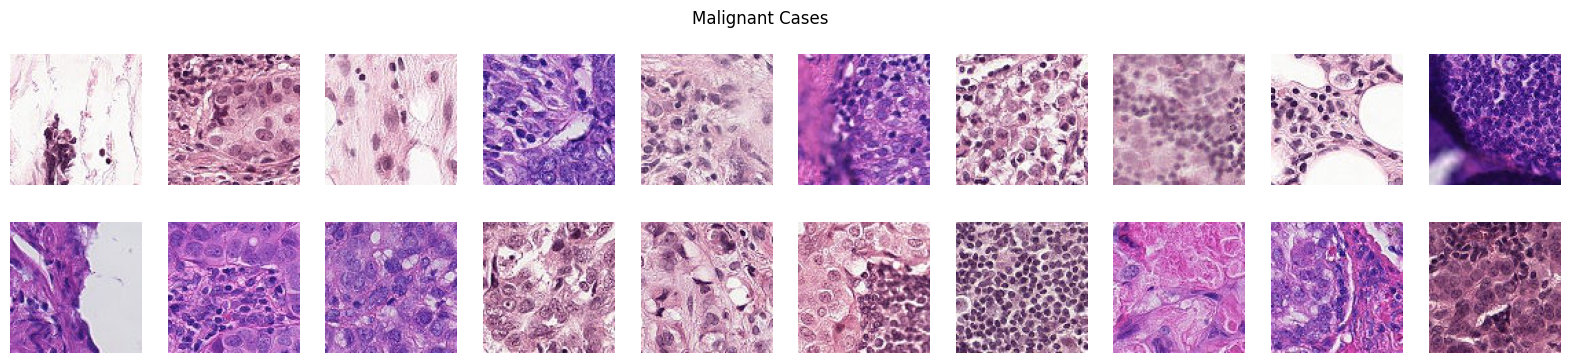

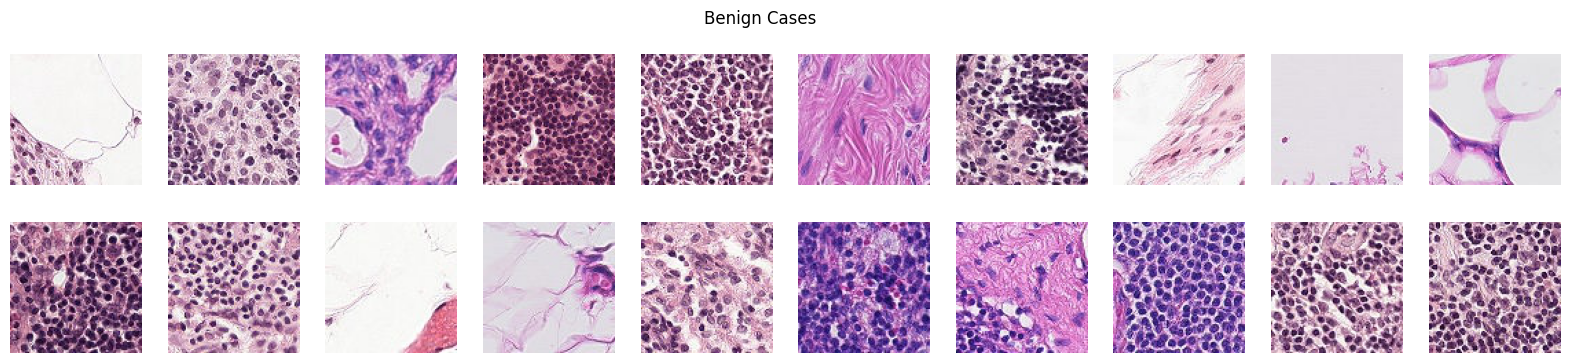

In [12]:
# Visualize the data
malignant = labels_df.loc[labels_df["label"] == 1]["id"].values
benign = labels_df.loc[labels_df["label"] == 0]["id"].values


def plot_fig(ids, title):
    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    for ax, img_id in zip(axes.flatten(), ids[:20]):
        img_path = os.path.join("train", f"{img_id}.tif")
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis("off")
    fig.suptitle(title)
    plt.show()


plot_fig(malignant, "Malignant Cases")
plot_fig(benign, "Benign Cases")

In [13]:
# Custom dataset for loading images and their labels

torch.manual_seed(0)

class pytorch_data(Dataset):

    def __init__(self, data_dir, transform, data_type="train"):

        # Get Image File Names
        cdm_data = os.path.join(data_dir, data_type)

        # get list of images in that directory
        file_names = os.listdir(cdm_data)
        rng = np.random.default_rng(0)
        idx_choose = rng.choice(
            np.arange(len(file_names)), 4000, replace=False
        ).tolist()
        file_names_sample = [file_names[x] for x in idx_choose]
        self.full_filenames = [os.path.join(cdm_data, f) for f in file_names_sample]

        # Get Labels
        labels_data = os.path.join(data_dir, "train_labels.csv")
        labels_df = pd.read_csv(labels_data)
        labels_df.set_index("id", inplace=True)  # set data frame index to id
        self.labels = [
            labels_df.loc[filename[:-4]].values[0] for filename in file_names_sample
        ]
        self.transform = transform

    def __len__(self):
        return len(self.full_filenames)

    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])
        image = self.transform(image)
        return image, self.labels[idx]


# define transformation that converts a PIL image into PyTorch tensors
data_transformer = transforms.Compose(
    [transforms.ToTensor(), transforms.Resize((46, 46))]
)

# Define an object of the custom dataset for the train folder.
img_dataset = pytorch_data("./", data_transformer, "train")

## Split the dataset

In [14]:
len_img = len(img_dataset)
len_train = int(0.8 * len_img)
len_val = len_img - len_train

# Split data 80/20
train_ts, val_ts = random_split(img_dataset, [len_train, len_val])

print("train dataset size:", len(train_ts))
print("validation dataset size:", len(val_ts))

train dataset size: 3200
validation dataset size: 800


# 2b Image Augmentation

- Among with pretrained models, image **transformation** and **image augmentation** are generally considered to be an essential parts of constructing deep learning models.
- Using image transformations, we can expand our dataset or resize and normalise it to achieve better model performance.
- Typical transformations include **vertical/horizontal flipping**, **rotating**, and **resizing**.
- We can use various image transformations for our binary classification model without making label changes; we can flip/rotate a **malignant** image but it will remain the same, **malignant**.
- We will apply these transformations to our training dataset to improve generalization when training the model and the validation dataset will remain unchanged to provide an unbiased evaluation.

### Transformations applied

- Flips the image horizontally with the probability of 0.5
- Flips the image vertically with the probability of 0.5
- Rotates the images randomly +-45 degrees.
- Convert images from PIL to PyTorch tensors

In [15]:
# Define the following transformations for the training dataset
tr_transf = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(45),
        transforms.ToTensor(),
    ]
)

# For the validation dataset, we don't need any augmentation; simply convert images into tensors
val_transf = transforms.Compose([transforms.ToTensor()])

# After defining the transformations, overwrite the transform functions of train_ts, val_ts
train_ts.transform = tr_transf
val_ts.transform = val_transf

## Creating Dataloaders

- Ready to create a PyTorch Dataloader. If we don't use **Dataloaders**, we have to write code to loop over datasets & extract a data batch; automated.
- We need to define a **batch_size** : The number of images extracted from the dataset each iteration


In [16]:
# Training DataLoader
train_dl = DataLoader(train_ts, batch_size=32, shuffle=True, num_workers=0)

# Validation DataLoader
val_dl = DataLoader(val_ts, batch_size=32, shuffle=False, num_workers=0)

# 3 Model Architecture

## Binary Classifier

For this project, I chose to build a custom CNN purely for learning how to do it. There are likely better models to use like a pretrained EfficientNet or ResNet but I preferred to tune my own model.

This model is designed for cancer detection in images by leveraging convolutional layers to automatically learn spatial patterns in medical images. The use of max-pooling helps reduce computational complexity while preserving important features, ensuring efficient processing. To prevent overfitting, dropout regularization is applied, improving generalization to unseen data. Finally, log softmax is used to stabilize numerical computations, making it well-suited for binary classification. With four convolutional layers, the model effectively captures both low- and high-level image features, allowing it to distinguish between malignant and benign tissue with greater accuracy.

The classifier is built in PyTorch with the following structure:

### **1. Convolutional Layers**

- Four convolutional layers (`conv1` to `conv4`), each followed by:
  - **ReLU activation** (`F.relu`) for non-linearity.
  - **Max-Pooling** (`F.max_pool2d(X, 2, 2)`) to downsample the feature maps.
- Each layer **doubles the number of filters**, progressively learning more complex patterns.

### **2. Fully Connected (FC) Layers**

- A **flattening operation** converts the final feature maps into a 1D vector.
- Two fully connected layers:
  - `fc1`: Reduces the feature dimensions.
  - `fc2`: Outputs **two logits** (one for each class).
- **Dropout (`F.dropout`)** is applied to prevent overfitting.

### **3. Output Layer**

- Uses **log softmax (`F.log_softmax`)**, which is ideal for classification tasks.


In [17]:
def find_conv_2d(hin, win, conv, pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride = conv.stride
    padding = conv.padding
    dilation = conv.dilation

    hout = np.floor(
        (hin + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1
    )
    wout = np.floor(
        (win + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1] + 1
    )

    if pool:
        hout /= pool
        wout /= pool
    return int(hout), int(wout)


# Neural Network
class Network(nn.Module):

    def __init__(self, params):

        super(Network, self).__init__()

        Cin, Hin, Win = params["shape_in"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h, w = find_conv_2d(Hin, Win, self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2 * init_f, kernel_size=3)
        h, w = find_conv_2d(h, w, self.conv2)
        self.conv3 = nn.Conv2d(2 * init_f, 4 * init_f, kernel_size=3)
        h, w = find_conv_2d(h, w, self.conv3)
        self.conv4 = nn.Conv2d(4 * init_f, 8 * init_f, kernel_size=3)
        h, w = find_conv_2d(h, w, self.conv4)

        # compute the flatten size
        self.num_flatten = h * w * 8 * init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, X):

        # Convolution & Pool Layers
        X = nn.functional.relu(self.conv1(X))
        X = nn.functional.max_pool2d(X, 2, 2)
        X = nn.functional.relu(self.conv2(X))
        X = nn.functional.max_pool2d(X, 2, 2)
        X = nn.functional.relu(self.conv3(X))
        X = nn.functional.max_pool2d(X, 2, 2)
        X = nn.functional.relu(self.conv4(X))
        X = nn.functional.max_pool2d(X, 2, 2)

        X = X.view(-1, self.num_flatten)

        X = nn.functional.relu(self.fc1(X))
        X = nn.functional.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return nn.functional.log_softmax(X, dim=1)

## Hyperparameter Tuning

Before training the final model, **hyperparameter tuning** is performed to find the best configuration for the network. Using **Optuna**, multiple trials test different values for key parameters such as the **number of filters, fully connected layer size, dropout rate, and learning rate**. The tuning process efficiently explores these options using **Bayesian Optimization (TPE Sampler)** and stops poor-performing trials early with **pruning**.

By optimizing these hyperparameters before full training, we improve **model accuracy, convergence speed, and generalization** while avoiding unnecessary computation. Once the best parameters are identified, the final model is trained using the full dataset for maximum performance.


In [18]:
"""Helper Functions"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):

    loss = loss_func(output, target)  # get loss
    pred = output.argmax(dim=1, keepdim=True)  # Get Output Class
    metric_b = pred.eq(target.view_as(pred)).sum().item()  # get performance metric

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model, loss_func, dataset_dl, opt=None):

    run_loss = 0.0
    t_metric = 0.0
    len_data = len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)  # get model output
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)  # get loss per batch
        run_loss += loss_b  # update running loss

        if metric_b is not None:  # update running metric
            t_metric += metric_b

    loss = run_loss / float(len_data)  # average loss value
    metric = t_metric / float(len_data)  # average metric value

    return loss, metric


# Define the objective function
def objective(trial):
    # Suggest hyperparameters
    initial_filters = trial.suggest_int("initial_filters", 8, 64, step=8)
    num_fc1 = trial.suggest_int("num_fc1", 50, 200, step=50)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)

    # Define model with suggested parameters
    params_model = {
        "shape_in": (3, 46, 46),
        "initial_filters": initial_filters,
        "num_fc1": num_fc1,
        "dropout_rate": dropout_rate,
        "num_classes": 2,
    }
    
    model = Network(params_model).to(device)
    loss_func = nn.NLLLoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    lr_scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)

    # Training parameters
    epochs = 5  # Reduce epochs for quick tuning
    best_loss = float("inf")

    for epoch in range(epochs):
        model.train()
        loss_epoch(model, loss_func, train_dl, optimizer)

        model.eval()
        with torch.no_grad():
            val_loss, _ = loss_epoch(model, loss_func, val_dl)

        # Update learning rate
        lr_scheduler.step(val_loss)

        # Track the best model
        if val_loss < best_loss:
            best_loss = val_loss

    return best_loss  # Minimize validation loss

# Run Optuna optimization
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
study = optuna.create_study(direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=10)

# Print best hyperparameters
print("Best hyperparameters:", study.best_params)


[I 2025-02-14 15:29:35,092] A new study created in memory with name: no-name-a17836aa-4d24-4a25-bcb7-dcb5b170f616
C:\Users\David\AppData\Local\Temp\ipykernel_35252\2074491290.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
[I 2025-02-14 15:30:26,355] Trial 0 finished with value: 0.5196232390403748 and parameters: {'initial_filters': 64, 'num_fc1': 100, 'dropout_rate': 0.4707728879299242, 'learning_rate': 2.460579012269336e-05}. Best is trial 0 with value: 0.5196232390403748.
[I 2025-02-14 15:31:10,917] Trial 1 finished with value: 0.5235090780258179 and parameters: {'initial_filters': 56, 'num_fc1': 50, 'dropout_rate': 0.4997023672003639, 'learning_rate': 4.890013067086459e-05}. Best is trial 0 with value: 0.5196232390403748.
[I 2025-02-14 15:31:41,526] 

Best hyperparameters: {'initial_filters': 48, 'num_fc1': 150, 'dropout_rate': 0.2173659339234397, 'learning_rate': 0.00018094117038471003}


## **Training Process**

### **1. Forward Pass**

During each training iteration, a batch of images is passed through the **Convolutional Neural Network (CNN)**. The model processes the images through multiple convolutional layers, applies activation functions, and outputs log probabilities for each class using **log softmax**.

### **2. Loss Computation**

The predicted log probabilities are compared with the actual labels using **Negative Log-Likelihood Loss (NLLLoss)**. This loss function measures how well the model's predictions match the true labels, penalizing incorrect classifications more heavily.

### **3. Backpropagation**

Once the loss is calculated, **backpropagation** is performed to compute gradients for all model parameters. The gradients indicate how much each parameter needs to be adjusted to reduce the error in future predictions.

### **4. Parameter Updates**

The **Adam optimizer** updates the model's parameters using the computed gradients. Adam dynamically adjusts learning rates for different parameters, ensuring more efficient convergence.

### **5. Learning Rate Adjustment**

To improve training efficiency, a **learning rate scheduler (`ReduceLROnPlateau`)** monitors the validation loss. If the loss does not improve for **20 consecutive epochs**, the learning rate is reduced by a factor of **0.5**, allowing the model to fine-tune its learning.

### **6. Repeating for Multiple Epochs**

The process repeats for multiple **epochs**, allowing the model to iteratively refine its feature extraction and classification capabilities. After training, the model is evaluated on a validation set to assess its performance.

By following this structured training approach, the model learns to effectively differentiate between **benign and malignant tissue** in histopathologic images, improving classification accuracy over time.


In [19]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group["lr"]


"""Training and Validation Loop"""
def train_val(model, params):

    # Get the parameters
    epochs = params["epochs"]
    loss_func = params["f_loss"]
    opt = params["optimiser"]
    train_dl = params["train"]
    val_dl = params["val"]
    lr_scheduler = params["lr_change"]
    weight_path = params["weight_path"]

    loss_history = {"train": [], "val": []}  # history of loss values in each epoch
    metric_history = {"train": [], "val": []}  # histroy of metric values in each epoch
    best_model_wts = copy.deepcopy(
        model.state_dict()
    )  # a deep copy of weights for the best performing model
    best_loss = float("inf")  # initialize best loss to a large value

    for epoch in tqdm(range(epochs)):

        # get current learning rate
        current_lr = get_lr(opt)
        print("Epoch {}/{}, current lr={}".format(epoch, epochs - 1, current_lr))

        # set model to training mode
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        # set model to evaluation mode
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl)

        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            # store weights into a local file
            torch.save(model.state_dict(), weight_path)

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts)

        print(
            f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}"
        )
        print("-" * 10)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

## **Loss Function and Optimizer**

### **Loss Function: Negative Log-Likelihood Loss (NLLLoss)**

The model uses **Negative Log-Likelihood Loss (NLLLoss)** with `reduction="sum"`, which computes the sum of negative log probabilities for the predicted class labels. This loss function is suitable because the model outputs **log probabilities** (`F.log_softmax` in the final layer). By penalizing incorrect predictions more severely, **NLLLoss** helps in optimizing the network for better classification performance.

### **Optimizer: Adam**

The optimizer chosen is **Adam (`torch.optim.Adam`)**, which combines the benefits of **momentum (from SGD)** and **adaptive learning rates (from RMSProp)**. It adjusts learning rates per parameter, making training efficient and reducing the need for manual tuning. The learning rate is set to **3e-4**, which provides a balance between convergence speed and stability.

### **Learning Rate Scheduler: ReduceLROnPlateau**

To further optimize training, a **learning rate scheduler (`ReduceLROnPlateau`)** is used. This monitors the **validation loss** and **reduces the learning rate by a factor of 0.5** if the loss does not improve for **20 consecutive epochs**. This strategy helps prevent the model from getting stuck in local minima and allows for fine-tuning as training progresses.

By combining **NLLLoss, Adam optimizer, and a learning rate scheduler**, the training process is designed to be efficient, stable, and adaptive, ensuring better performance on the cancer classification task.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19, current lr=0.00018094117038471003
train loss: 0.657285, dev loss: 0.600503, accuracy: 74.00
----------
Epoch 1/19, current lr=0.00018094117038471003
train loss: 0.533956, dev loss: 0.533324, accuracy: 75.12
----------
Epoch 2/19, current lr=0.00018094117038471003
train loss: 0.500900, dev loss: 0.506918, accuracy: 75.50
----------
Epoch 3/19, current lr=0.00018094117038471003
train loss: 0.487735, dev loss: 0.523201, accuracy: 75.50
----------
Epoch 4/19, current lr=0.00018094117038471003
train loss: 0.479014, dev loss: 0.487521, accuracy: 78.38
----------
Epoch 5/19, current lr=0.00018094117038471003
train loss: 0.479864, dev loss: 0.481256, accuracy: 76.88
----------
Epoch 6/19, current lr=0.00018094117038471003
train loss: 0.461455, dev loss: 0.468369, accuracy: 79.00
----------
Epoch 7/19, current lr=0.00018094117038471003
train loss: 0.458322, dev loss: 0.464877, accuracy: 78.12
----------
Epoch 8/19, current lr=0.00018094117038471003
train loss: 0.442132, dev loss: 0.

Text(0.5, 1.0, 'Convergence History')

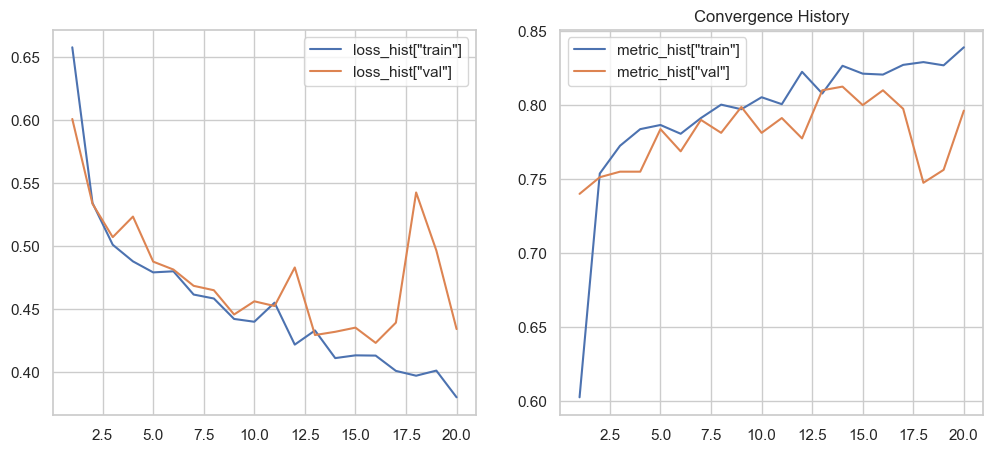

In [20]:
# Get the best hyperparameters
best_params = study.best_params
params_model = {
    "shape_in": (3, 46, 46),
    "initial_filters": best_params["initial_filters"],
    "num_fc1": best_params["num_fc1"],
    "dropout_rate": best_params["dropout_rate"],
    "num_classes": 2,
}
lr_best = best_params["learning_rate"]

# Create the model
cnn_model = Network(params_model).to(device)
opt = optim.Adam(cnn_model.parameters(), lr=lr_best)

params_train = {
    "train": train_dl,
    "val": val_dl,
    "epochs": 20,
    "optimiser": torch.optim.Adam(cnn_model.parameters(), lr=lr_best),
    "lr_change": ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=20),
    "f_loss": nn.NLLLoss(reduction="sum"),
    "weight_path": "weights.pt",
}

# train and validate the model
cnn_model, loss_hist, metric_hist = train_val(cnn_model, params_train)

# Results and Analysis



Text(0.5, 1.0, 'Convergence History')

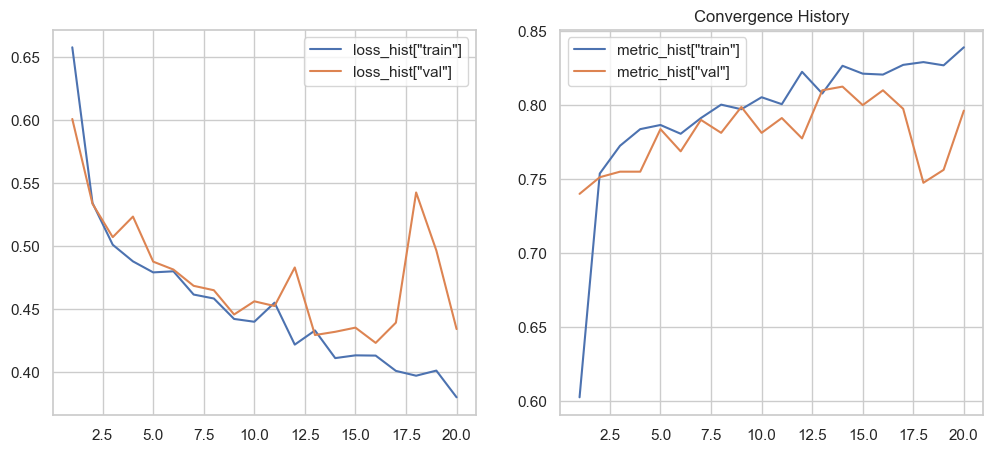

In [35]:
# Plot the convergence history
sns.set_theme(style="whitegrid")
epochs = params_train["epochs"]
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(
    x=[*range(1, epochs + 1)],
    y=loss_hist["train"],
    ax=ax[0],
    label='loss_hist["train"]',
)
sns.lineplot(
    x=[*range(1, epochs + 1)], y=loss_hist["val"], ax=ax[0], label='loss_hist["val"]'
)
sns.lineplot(
    x=[*range(1, epochs + 1)],
    y=metric_hist["train"],
    ax=ax[1],
    label='metric_hist["train"]',
)
sns.lineplot(
    x=[*range(1, epochs + 1)],
    y=metric_hist["val"],
    ax=ax[1],
    label='metric_hist["val"]',
)
plt.title("Convergence History")

In [43]:
class pytorchdata_test(Dataset):

    def __init__(self, data_dir, transform, data_type="train"):

        path2data = os.path.join(data_dir, data_type)
        filenames = os.listdir(path2data)
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]

        # labels are in a csv file named train_labels.csv
        csv_filename = "sample_submission.csv"
        path2csvLabels = os.path.join(data_dir, csv_filename)
        labels_df = pd.read_csv(path2csvLabels)

        # set data frame index to id
        labels_df.set_index("id", inplace=True)

        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]
        self.transform = transform

    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)

    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])  # PIL image
        image = self.transform(image)
        return image, self.labels[idx]


# load any model weights for the model
cnn_model.load_state_dict(torch.load("weights.pt"))


# sample submission
path_sub = "sample_submission.csv"
labels_df = pd.read_csv(path_sub)
labels_df.head()
labels_df.shape


data_transformer = transforms.Compose(
    [transforms.ToTensor(), transforms.Resize((46, 46))]
)

img_dataset_test = pytorchdata_test("./", data_transformer, data_type="test")
print(len(img_dataset_test), "samples found")

57458 samples found


In [45]:
def inference(model, dataset, device, num_classes=2):
    len_data = len(dataset)
    y_out = torch.zeros(len_data, num_classes)  # initialize output tensor on CPU
    model = model.to(device)  # move model to device

    ids = []
    preds = []

    with torch.no_grad():
        for i in tqdm(range(len_data)):
            x, _ = dataset[i]
            y_out[i] = model(x.unsqueeze(0).to(device))
            ids.append(dataset.full_filenames[i].split("/")[-1].replace(".tif", ""))
            ids.append(dataset.full_filenames[i].split("/")[-1].replace("test\\", ""))
            preds.append(np.exp(y_out[i, 1].item()))  # Probability of tumor presence

    return ids, preds


# Run inference
ids, preds = inference(cnn_model, img_dataset_test, device)

# Create submission file
submission_df = pd.DataFrame({"id": ids, "label": preds})
submission_df.to_csv("submission.csv", index=False)
print("submission.csv file saved!")

  0%|          | 0/57458 [00:00<?, ?it/s]

submission.csv file saved!


# Conclusion

The convergence plots provide insights into the model's learning behavior and overall performance. The left plot displays the loss curves for both training and validation datasets, while the right plot shows the progression of the selected evaluation metric across epochs.

## Performance Evaluation

The loss curves indicate that the training loss consistently decreases, which suggests that the model is learning effectively. However, the validation loss does not follow the same smooth decreasing trend and exhibits some fluctuations, particularly after epoch 10. This could indicate potential overfitting, where the model performs well on the training data but struggles to generalize to unseen data.

On the metric history plot, the training performance steadily improves, reaching approximately 85% by the final epoch. The validation metric follows a similar trend but remains slightly lower, peaking around 80%. The gap between training and validation metrics suggests that while the model is effective, it does not generalize perfectly to new data, further reinforcing the overfitting concern.

## Key Learnings & Takeaways

- Improvement in Training Performance: The model successfully learns patterns in the training data, as evidenced by the steady decrease in loss and increasing evaluation metric.
- Validation Instability: The validation loss curve fluctuates, indicating possible generalization issues. This suggests that while the model has learned meaningful patterns, it may also be fitting noise in the training data.
- Overfitting Indicators: The noticeable gap between training and validation performance implies that the model might be too specialized to the training data, leading to reduced effectiveness on unseen examples.

## Ways to Improve the Model

These are some ways I could potentially enhance the model:

- Regularization: Introduce techniques like Dropout or L2 weight decay to prevent the model from memorizing training data.
- Additional Data Augmentation: Expand the training dataset by applying more or different transformations such as rotation, flipping, and contrast adjustments to improve robustness.
- Early Stopping: Implement early stopping to halt training when validation performance begins to decline, preventing unnecessary overfitting.
- More Hyperparameter Tuning: Experiment with additional learning rates, batch sizes, and network architectures to find a more optimal configuration.

Overall, I am satisfied with how the model performed given the amount of time spent on this project.